In [75]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [83]:
df_aq = pd.read_csv("../input/beijing_1701_1803.csv")
df_station = pd.read_csv("../input/Beijing_AirQuality_Stations.csv")
target_cols = ['PM2.5', 'PM10', 'O3']

df_aq.utc_time = pd.to_datetime(df_aq.utc_time)

dfs = []
for stationId in df_aq.stationId.unique():
    df = df_aq[df_aq['stationId']==stationId]
    df = df.resample('1H', on='utc_time').sum()
    df = df.reset_index()
    df['stationId'] = stationId
    dfs.append(df)
df_ = pd.concat(dfs)

In [39]:
idx_to_station = {k:v for k,v in df_station.Station_ID.iteritems()}
near_stations = []
for k, row in df_station.iterrows():
    result =  np.sqrt((111*(df_station.longitude-row[1]))**2 + (74*(df_station.latitude-row[2]))**2).nsmallest(4)
    near_idx = np.sqrt((111*(df_station.longitude-row[1]))**2 + (74*(df_station.latitude-row[2]))**2).nsmallest(4).index[1:4].tolist()
    near_station = [idx_to_station[idx] for idx in near_idx]
    near_stations.append(near_station)
    print(k, row[0])
    print(result, "\n")
    
df_station_near = pd.concat([df_station, pd.DataFrame(near_stations, columns=['near_1', 'near_2', 'near_3'])], axis=1 )

0 dongsi_aq
0     0.000000
30    3.300267
1     3.370048
4     4.506715
dtype: float64 

1 tiantan_aq
1     0.000000
31    1.621681
30    1.643067
0     3.370048
dtype: float64 

2 guanyuan_aq
2     0.000000
32    2.157452
3     4.040461
33    6.288367
dtype: float64 

3 wanshouxigong_aq
3     0.000000
33    2.409265
2     4.040461
31    4.664349
dtype: float64 

4 aotizhongxin_aq
4     0.000000
0     4.506715
32    5.716710
30    6.146011
dtype: float64 

5 nongzhanguan_aq
5     0.000000
34    2.446481
0     4.919748
1     7.083157
dtype: float64 

6 wanliu_aq
6     0.000000
2     7.192861
32    7.302417
8     8.949106
dtype: float64 

7 beibuxinqu_aq
7      0.000000
8      7.471527
17    11.267700
11    13.071216
dtype: float64 

8 zhiwuyuan_aq
8     0.000000
11    6.994566
7     7.471527
6     8.949106
dtype: float64 

9 fengtaihuayuan_aq
9    0.000000
3    8.178674
2    8.258877
6    9.218868
dtype: float64 

10 yungang_aq
10    0.000000
12    6.168689
11    7.883345
18    9.467663

In [40]:
# try:
#     del df_impute
# except:
#     pass
# df_near = pd.merge(df_, df_station_near, 'left', left_on='stationId', right_on='Station_ID')
# nears = ['near_1', 'near_2', 'near_3']
# for near in nears:
#     near_col = df_impute.iloc[0][near]
#     df_right = df_impute[target_cols + ['stationId','utc_time']][df_impute.stationId==near_col]
#     df_impute = pd.merge(df_impute, df_right, 
#                          how='left', suffixes=('', '_'+ near),
#                          left_on=['utc_time', near], 
#                          right_on=['utc_time', 'stationId'])

In [41]:
# def stKNN(df_impute, station):
#     MSEs = []
#     df_stKNNs_ = []
#     df_impute_station = df_impute[df_impute.stationId==station]
#     df_impute_station = df_impute_station.sort_values('utc_time')
    
#     for target in target_cols:
#         print(station, target)
        
#         # Temperial 
#         for i in [-2, -1, 1, 2]:
#             df_impute_station[target + "_t{0:+}".format(i)] = df_impute_station[target].shift(i*-1)
            
#         cols = [target + "_t{0:+}".format(i) for i in [-2, -1, 1, 2]]
#         cols += [target+'_near_1', target+'_near_2', target+'_near_3', target, 'utc_time']
#         df_stKNN_ = df_impute_station[cols]
#         notnull_idxs = df_stKNN_[target].notnull().index # for evaluation

#         # Iterate it until no null value
#         while df_stKNN_[df_stKNN_[target].isnull()].shape[0]!=0:
#             df_stKNN_[target+"_pred"] = df_stKNN_[cols].mean(axis=1)
#             df_stKNN_.loc[df_stKNN_[target].isnull(), target] = df_stKNN_[target+'_pred']
#             for i in [-2, -1, 1, 2]:
#                 df_stKNN_[target + "_t{0:+}".format(i)] = df_stKNN_[target].shift(i*-1)
#             print(df_stKNN_[df_stKNN_[target].isnull()].shape[0], end=" ")

#         df_stKNNs_.append(df_stKNN_[['utc_time', target]])
#         mse = mean_absolute_error(df_stKNN_[target][notnull_idxs], df_stKNN_[target+'_pred'][notnull_idxs])
#         MSEs.append([station + "_" + target, mse])

#     df_stKNN = pd.concat(df_stKNNs_, axis=1)
#     df_stKNN = df_stKNN.T.drop_duplicates().T
#     df_stKNN['stationId'] = station
#     return df_stKNN, MSEs
    
# df_stKNN, MSEs = stKNN(df_impute, station="zhiwuyuan_aq" )

In [42]:
# Spatial 
def spatial_step(df, target):
    for near in nears:
        df = pd.merge(df, df[[target, 'stationId','utc_time']], 
                     how='left', suffixes=('', '_'+ near),
                     left_on=['utc_time', near], 
                     right_on=['utc_time', 'stationId'])
    return df

# Temperial 
def temporal_step(df, target):
    dfs_ = []
    nulls = []
    for station in df.stationId.unique():
        df_ = df[df.stationId==station]
        df_ = df_.sort_values('utc_time')

        for i in [-2, -1, 1, 2]:
            df_[target + "_t{0:+}".format(i)] = df_[target].shift(i*-1)

        cols = [target + "_t{0:+}".format(i) for i in [-2, -1, 1, 2]]
        cols += [target+'_near_1', target+'_near_2', target+'_near_3', target, 'utc_time']

        df_[target+"_pred"] = df_[cols].mean(axis=1)

        # Update valie
        null_idxs = station_to_null_idxs[station]
        df_.loc[null_idxs, target] = df_[target + '_pred']
#         df_[target] = df_[target + '_pred'] # Wrong version
        for i in [-2, -1, 1, 2]:
            df_[target + "_t{0:+}".format(i)] = df_[target].shift(i*-1)
        null = df_[df_[target].isnull()].shape[0]
        nulls.append(null)
#         print(N_null, station, target)
        dfs_.append(df_[['utc_time', 'stationId', target]])
    return dfs_, nulls

target="PM10"
station_to_null_idxs = {}
station_to_notnull_idxs = {}
MSEs = []

nears = ['near_1', 'near_2', 'near_3']

df_impute = pd.merge(df_, df_station_near, 'left', left_on='stationId', right_on='Station_ID')

for station in df_impute.stationId.unique():
    df_ = df_impute[df_impute.stationId==station]
    df_ = df_.sort_values('utc_time')
    station_to_null_idxs[station] = df_[target].isnull() # for params update
    station_to_notnull_idxs[station] = df_[target].notnull() # for evaluation

In [43]:
N_nulls = 999
while N_nulls>0:
    df_impute = spatial_step(df_impute, target)
    df_imputes, nulls = temporal_step(df_impute, target)
    df_impute = pd.concat(df_imputes)
    df_impute = pd.merge(df_impute, df_station_near, 'left', left_on='stationId', right_on='Station_ID')
    N_nulls = sum(nulls)
    print(N_nulls, nulls)
# # df_imputes_.append(df_impute[['utc_time', target]])
# # mse = mean_absolute_error(df_impute[target][notnull_idxs], df_impute[target+'_pred'][notnull_idxs])
# # MSEs.append([station + "_" + target, mse])
# a, b = stKNN(df_impute, station="zhiwuyuan_aq")

40153 [1253, 898, 1160, 758, 1275, 1677, 1115, 1036, 950, 1103, 952, 1101, 1049, 1231, 1160, 1232, 1436, 1321, 880, 1098, 1518, 1327, 1004, 1147, 1226, 1121, 1012, 1318, 1002, 869, 1193, 1359, 998, 1053, 1321]
23832 [796, 608, 726, 546, 785, 944, 758, 601, 661, 655, 636, 712, 620, 753, 744, 643, 808, 658, 577, 729, 908, 646, 597, 614, 623, 645, 637, 684, 633, 551, 641, 653, 575, 702, 763]
17958 [514, 485, 553, 459, 584, 579, 506, 478, 551, 512, 500, 552, 475, 587, 561, 489, 536, 492, 469, 564, 552, 495, 477, 489, 481, 500, 495, 501, 503, 458, 495, 499, 468, 570, 529]
15343 [434, 426, 462, 412, 474, 460, 435, 420, 483, 434, 426, 460, 413, 506, 465, 416, 436, 420, 417, 462, 442, 426, 419, 426, 416, 431, 419, 432, 439, 410, 426, 429, 421, 497, 449]
14134 [397, 401, 416, 391, 418, 404, 401, 396, 437, 396, 394, 415, 394, 455, 421, 392, 397, 391, 393, 412, 398, 397, 395, 398, 393, 397, 395, 395, 407, 393, 396, 402, 395, 443, 409]
13466 [380, 382, 385, 379, 389, 388, 382, 383, 401, 379, 381, 

1904 [54, 54, 55, 54, 54, 54, 54, 54, 54, 54, 54, 54, 56, 56, 54, 54, 56, 54, 54, 54, 54, 54, 54, 54, 54, 54, 56, 55, 54, 54, 56, 56, 54, 54, 54]
1764 [50, 50, 51, 50, 50, 50, 50, 50, 50, 50, 50, 50, 52, 52, 50, 50, 52, 50, 50, 50, 50, 50, 50, 50, 50, 50, 52, 51, 50, 50, 52, 52, 50, 50, 50]
1624 [46, 46, 47, 46, 46, 46, 46, 46, 46, 46, 46, 46, 48, 48, 46, 46, 48, 46, 46, 46, 46, 46, 46, 46, 46, 46, 48, 47, 46, 46, 48, 48, 46, 46, 46]
1484 [42, 42, 43, 42, 42, 42, 42, 42, 42, 42, 42, 42, 44, 44, 42, 42, 44, 42, 42, 42, 42, 42, 42, 42, 42, 42, 44, 43, 42, 42, 44, 44, 42, 42, 42]
1344 [38, 38, 39, 38, 38, 38, 38, 38, 38, 38, 38, 38, 40, 40, 38, 38, 40, 38, 38, 38, 38, 38, 38, 38, 38, 38, 40, 39, 38, 38, 40, 40, 38, 38, 38]
1204 [34, 34, 35, 34, 34, 34, 34, 34, 34, 34, 34, 34, 36, 36, 34, 34, 36, 34, 34, 34, 34, 34, 34, 34, 34, 34, 36, 35, 34, 34, 36, 36, 34, 34, 34]
1064 [30, 30, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 32, 32, 30, 30, 32, 30, 30, 30, 30, 30, 30, 30, 30, 30, 32, 31, 30, 30

In [44]:
# df_stKNN = spatial_step(df_stKNN, target)
# df_stKNNs = temporal_step(df_stKNN, target)
# df_stKNN = pd.concat(df_stKNNs)
# df_stKNN = pd.merge(df_stKNN, df_station_near, 'left', left_on='stationId', right_on='Station_ID')

# # # df_stKNNs_.append(df_stKNN[['utc_time', target]])
#     notnull_idxs = station_to_notnull_idxs[station]
#     mse = mean_absolute_error(df_[target][notnull_idxs], df_[target+'_pred'][notnull_idxs])
# # # MSEs.append([station + "_" + target, mse])
# # a, b = stKNN(df_stKNN, station="zhiwuyuan_aq")

In [45]:
# tmp.loc[station_to_null_idxs['aotizhongxin_aq'], 'PM10'] = 1

In [109]:
df = pd.merge(df_, df_impute[['utc_time', 'stationId', 'PM10']], how='left', suffixes=("", "_pred"),
              left_on=['utc_time', 'stationId'],
              right_on=['utc_time', 'stationId'],
             )

In [110]:
df

,utc_time,PM2.5,PM10,NO2,CO,O3,SO2,stationId,PM10_pred
0,2017-01-01 22:00:00,453.0,467.0,156.0,7.2,3.0,9.0,aotizhongxin_aq,467.000000
1,2017-01-01 23:00:00,417.0,443.0,143.0,6.8,2.0,8.0,aotizhongxin_aq,443.000000
2,2017-01-02 00:00:00,395.0,467.0,141.0,6.9,3.0,8.0,aotizhongxin_aq,467.000000
3,2017-01-02 01:00:00,420.0,484.0,139.0,7.4,3.0,9.0,aotizhongxin_aq,484.000000
4,2017-01-02 02:00:00,453.0,520.0,157.0,7.6,4.0,9.0,aotizhongxin_aq,520.000000
5,2017-01-02 03:00:00,429.0,NaN,141.0,6.5,3.0,9.0,aotizhongxin_aq,470.998476
6,2017-01-02 04:00:00,211.0,NaN,110.0,3.3,NaN,11.0,aotizhongxin_aq,451.306961
7,2017-01-02 05:00:00,116.0,NaN,87.0,2.2,4.0,13.0,aotizhongxin_aq,424.100020
8,2017-01-02 06:00:00,51.0,NaN,58.0,1.3,26.0,14.0,aotizhongxin_aq,401.935667
9,2017-01-02 07:00:00,38.0,NaN,55.0,1.1,28.0,14.0,aotizhongxin_aq,380.150756


/home/tony/venv/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


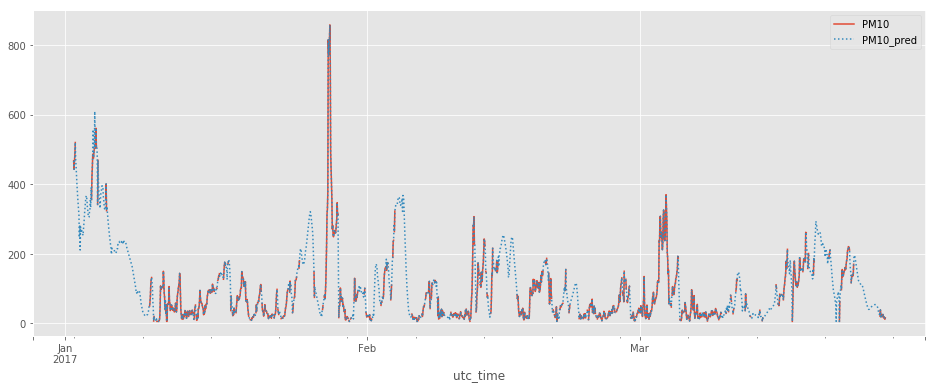

In [113]:
tmp = df[['utc_time','PM10', 'PM10_pred']][df.stationId=="aotizhongxin_aq"]
tmp = tmp.sort_values(by='utc_time')
tmp[:2000].plot(x='utc_time', y=['PM10', 'PM10_pred'], figsize=(16,6), style={'PM10': '-', 'PM10_pred': ':'})

In [115]:
df_impute

,utc_time,stationId,PM10,Station_ID,longitude,latitude,station_type,near_1,near_2,near_3
0,2017-01-01 22:00:00,aotizhongxin_aq,467.000000,aotizhongxin_aq,116.397,39.982,Urban,dongsi_aq,xizhimenbei_aq,qianmen_aq
1,2017-01-01 23:00:00,aotizhongxin_aq,443.000000,aotizhongxin_aq,116.397,39.982,Urban,dongsi_aq,xizhimenbei_aq,qianmen_aq
2,2017-01-02 00:00:00,aotizhongxin_aq,467.000000,aotizhongxin_aq,116.397,39.982,Urban,dongsi_aq,xizhimenbei_aq,qianmen_aq
3,2017-01-02 01:00:00,aotizhongxin_aq,484.000000,aotizhongxin_aq,116.397,39.982,Urban,dongsi_aq,xizhimenbei_aq,qianmen_aq
4,2017-01-02 02:00:00,aotizhongxin_aq,520.000000,aotizhongxin_aq,116.397,39.982,Urban,dongsi_aq,xizhimenbei_aq,qianmen_aq
5,2017-01-02 03:00:00,aotizhongxin_aq,470.998476,aotizhongxin_aq,116.397,39.982,Urban,dongsi_aq,xizhimenbei_aq,qianmen_aq
6,2017-01-02 04:00:00,aotizhongxin_aq,451.306961,aotizhongxin_aq,116.397,39.982,Urban,dongsi_aq,xizhimenbei_aq,qianmen_aq
7,2017-01-02 05:00:00,aotizhongxin_aq,424.100020,aotizhongxin_aq,116.397,39.982,Urban,dongsi_aq,xizhimenbei_aq,qianmen_aq
8,2017-01-02 06:00:00,aotizhongxin_aq,401.935667,aotizhongxin_aq,116.397,39.982,Urban,dongsi_aq,xizhimenbei_aq,qianmen_aq
9,2017-01-02 07:00:00,aotizhongxin_aq,380.150756,aotizhongxin_aq,116.397,39.982,Urban,dongsi_aq,xizhimenbei_aq,qianmen_aq
